# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## План работы

- Открыть файлы с данными
- Проверить данные и откорректировать их, если потребуется.
- Изучить аномалии в столбцах.
- Подготовить выборки для обучения моделей.
- Обучить модель LightGBM и обычную модель (не бустинг), оценить их качество метрикой RMSE. 
- Выбрать лучшую модель и проверить её на тестовой выборке.
- Написать общий вывод.

## Цель работы

- Построить модель, которая сможет определять рыночную смтоимость автомобиля с качеством RMSE не более 2500

## Описание данных

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак: 
- Price — цена (евро)

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Подготовка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder
)
from sklearn.compose import ColumnTransformer
import numpy as np
from time import time
from sklearn.dummy import DummyRegressor

In [3]:
# загрузка данных

data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- Есть пропуски в столбцах VehicleType, Gearbox, Model, FuelType, Repaired; 
- Некоторые столбцы имеют неверный тип данных, например, столбец DateCrawled, DateCreated и LastSeen, которые содержат информацию о дате; 
- Кажется, что описанные выше столбцы с датами никак не повлияют на обучаемость моделей, т.к. даты не связаны напрямую с самими автомобилями, как, например, столбцы Kilometer, Power или Repaired. В таком случае столбцы с датами можно просто удалить; 
- Также неинформативными кажутся столбцы RegistrationMonth и NumberOfPictures. Первый содержит только номер месяца, что по сути никак не влияет на стоимость авто, а второй содержит количество фотографий, что тоже никак не может повлиять на стоимость авто. Но избавляться от них пока не буду, если что вернусь к ним позднее.

In [5]:
# начнем с удаления неинформативных столбцов
columns_to_remove = ['DateCrawled', 'DateCreated', 'LastSeen']
data = data.drop(columns_to_remove, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
 11  NumberOfPictures   354369 non-null  int64 
 12  PostalCode         354369 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.1+ MB


In [6]:
# посмтрим пропущенные значения в столбцах
missing_rows = data[data['VehicleType'].isnull()]
display(missing_rows)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
16,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,0,38871
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,0,49716
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,0,31139
31,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,0,37075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,0,61169
354351,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,0,87700
354361,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,0,51371
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,0,2694


In [7]:
data['VehicleType'].unique().tolist()

[nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'other']

- Самый просто вариант -- удалить пропуски. 
- Самый сложный, но более действенный в плане метрики качества обученной модели, это заполнить каждый пропуск в столбце VehicleType, основываясь на общедоступных данных по модели, т.е. столбцу Model, однако этот способ займет много времени.
- Начну с самого простого - удаления. В последствии, если RMSE будет выше 2500, можно будет вернуться и попробовать заполнить пропуски данными из интернета.

In [8]:
print('Размер датасета до удаления пропусков:', data.shape)

Размер датасета до удаления пропусков: (354369, 13)


In [9]:
# удаляю пропуски из столбца VehicleType
data = data.dropna(subset=['VehicleType'])
print('Размер датасета после удаления пропусков:', data.shape)

Размер датасета после удаления пропусков: (316879, 13)


Размер датасета сократился, но не значительно. Перейдем к следующим столбцам.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316879 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              316879 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   316879 non-null  int64 
 3   Gearbox            307016 non-null  object
 4   Power              316879 non-null  int64 
 5   Model              304002 non-null  object
 6   Kilometer          316879 non-null  int64 
 7   RegistrationMonth  316879 non-null  int64 
 8   FuelType           301279 non-null  object
 9   Brand              316879 non-null  object
 10  Repaired           266296 non-null  object
 11  NumberOfPictures   316879 non-null  int64 
 12  PostalCode         316879 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 33.8+ MB


Пропуски есть еще в столбцах Gearbox, Model, FuelType, Repaired.

In [11]:
missing_rows_gear = data[data['Gearbox'].isnull()]
display(missing_rows_gear)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,0,24148
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,0,44145
69,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,0,47249
110,350,small,1998,NaN,0,corsa,150000,2,petrol,opel,NaN,0,82110
115,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,0,37520
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354221,4300,small,2009,NaN,0,ibiza,150000,3,petrol,seat,no,0,32756
354260,399,other,1994,NaN,1103,3er,150000,0,NaN,bmw,NaN,0,56235
354285,3500,small,2001,NaN,75,corsa,90000,4,petrol,opel,no,0,49740
354288,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,0,12057


In [12]:
data['Gearbox'].unique().tolist()

['manual', 'auto', nan]

Взять информацию по трансмиссии в данном случае негде, так как даже, если отталкиваться от модели авто, они зачастую бывают как с ручной, так и с автоматической трансмиссией. Поэтому удалю пропуски в этом столбце.

In [13]:
print('Размер датасета до удаления пропусков:', data.shape)
# удаляю пропуски из столбца Gearbox
data = data.dropna(subset=['Gearbox'])
print('Размер датасета после удаления пропусков:', data.shape)

Размер датасета до удаления пропусков: (316879, 13)
Размер датасета после удаления пропусков: (307016, 13)


In [14]:
missing_rows_model = data[data['Model'].isnull()]
display(missing_rows_model)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,0,53721
81,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,0,45665
135,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,0,38709
160,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,0,26969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354077,200,small,1998,manual,37,NaN,150000,4,petrol,volkswagen,yes,0,26382
354080,4300,small,2008,auto,0,NaN,150000,3,NaN,honda,NaN,0,30627
354234,5000,sedan,2002,auto,170,NaN,150000,0,petrol,audi,no,0,85221
354245,560,small,2001,auto,170,NaN,90000,0,petrol,fiat,yes,0,55743


Аналогично, проще и логичнее удалить пропуски, так как заполнить их подходящими значениями будет очень сложно или невозможно.

In [15]:
print('Размер датасета до удаления пропусков:', data.shape)
# удаляю пропуски из столбца Model
data = data.dropna(subset=['Model'])
print('Размер датасета после удаления пропусков:', data.shape)

Размер датасета до удаления пропусков: (307016, 13)
Размер датасета после удаления пропусков: (295258, 13)


In [16]:
missing_rows_ftype = data[data['FuelType'].isnull()]
display(missing_rows_ftype)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,0,27472
13,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,0,90762
36,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,0,2943
41,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,0,33649
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,0,88433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354236,1799,wagon,2005,manual,180,signum,150000,1,NaN,opel,yes,0,8064
354265,3000,sedan,2001,auto,150,a4,150000,8,NaN,audi,yes,0,71332
354326,1300,small,1999,manual,75,2_reihe,125000,0,NaN,peugeot,NaN,0,35102
354327,2999,wagon,2004,manual,234,vectra,100000,1,NaN,opel,NaN,0,83364


Аналогично с трансмиссией. Авто одной и той же модели могут быть и дизельные, и бензиновые. Например 1 строчка Volkswagen Golf 1998 г.в. есть как бензиновый двигатель, так и дизельный. 
Поэтому удалю пропущенные значения.

In [17]:
print('Размер датасета до удаления пропусков:', data.shape)
# удаляю пропуски из столбца FuelType
data = data.dropna(subset=['FuelType'])
print('Размер датасета после удаления пропусков:', data.shape)

Размер датасета до удаления пропусков: (295258, 13)
Размер датасета после удаления пропусков: (284126, 13)


In [18]:

missing_rows_rp = data[data['Repaired'].isnull()]
display(missing_rows_rp)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,0,94505
12,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,0,37269
42,12500,sedan,2006,auto,231,5er,150000,11,gasoline,bmw,NaN,0,46119
44,3900,small,2008,auto,61,fortwo,80000,6,petrol,smart,NaN,0,21073
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354341,699,sedan,1999,manual,101,vectra,150000,3,petrol,opel,NaN,0,65936
354349,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,0,56472
354356,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,0,88477
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,0,18246


Здесь у нас уже много пропусков, которые удалять не хочется, особенно учитывая, что есть столбец с пробегом, по которому можно попробовать понять был ли авто в ремонте. Можно поискать в интернете средний пробег после, которого авто попадает в ремонт, и заполнить пропуски. 

В среднем проблемы начинаются после 100 - 120 пробега. Возьму порог в 120 000 км

In [19]:
for index, row in data.iterrows():
    if pd.isna(row['Repaired']):
        if row['Kilometer'] < 120000:
            data.loc[index, 'Repaired'] = 'no'
        else:
            data.loc[index, 'Repaired'] = 'yes'

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              284126 non-null  int64 
 1   VehicleType        284126 non-null  object
 2   RegistrationYear   284126 non-null  int64 
 3   Gearbox            284126 non-null  object
 4   Power              284126 non-null  int64 
 5   Model              284126 non-null  object
 6   Kilometer          284126 non-null  int64 
 7   RegistrationMonth  284126 non-null  int64 
 8   FuelType           284126 non-null  object
 9   Brand              284126 non-null  object
 10  Repaired           284126 non-null  object
 11  NumberOfPictures   284126 non-null  int64 
 12  PostalCode         284126 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 38.4+ MB


Итого: 
- Заполнены пропуски в столбце Repaired 
- В остальных столбцах пропуски были удалены

Можно переходить к поиску аномалий

In [21]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,284126.000000,284126.000000,284126.000000,284126.000000,284126.000000,284126.0,284126.000000
mean,4847.265516,2002.567861,117.727213,128261.651521,6.071577,0.0,51094.901026
std,4637.056831,6.243808,169.107292,36739.971043,3.548155,0.0,25775.683653
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30851.000000
50%,3199.000000,2003.000000,109.000000,150000.000000,6.000000,0.0,50170.000000
75%,6999.000000,2007.000000,147.000000,150000.000000,9.000000,0.0,71706.000000
max,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Что сразу бросается в глаза:

- столбец Price: min = 0. Кажется, что в данном случае не было речи о бесплатных авто
- столбец RegistrationYear: min = 1910. В теории возможно, но нужно проверить
- столбец Power: min = 0. Такого точно быть не может. Помимо нулевой мощности max = 20000, во что тоже верится с трудом.
- столбец Kilometer: на первый взгляд все ок
- столбец RegistrationMonth: min = 0. Не зарегистрированный авто? Ошибка?
- столбец NumberOfPictures: все значения равны 0? Можно от него тогда избавиться, т.к. он неинформативен.

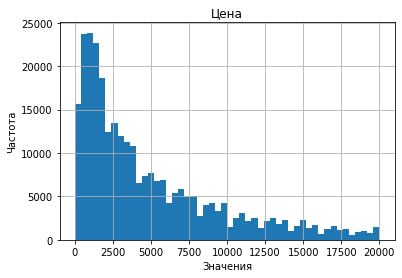

In [22]:
# построю графики для столбцов для наглядности
plt.hist(data['Price'], bins=50)

plt.title('Цена')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

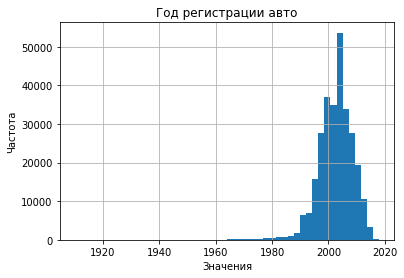

In [23]:
plt.hist(data['RegistrationYear'], bins=50)

plt.title('Год регистрации авто')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)


plt.show()

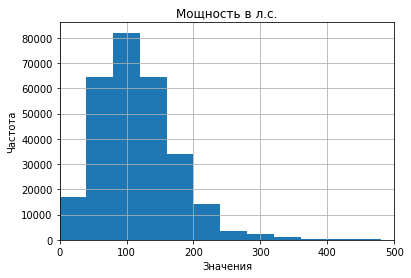

In [24]:
plt.hist(data['Power'], bins=500)

plt.title('Мощность в л.с.')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)
plt.xlim(0,500)

plt.show()

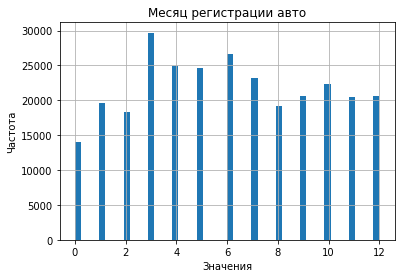

In [25]:
plt.hist(data['RegistrationMonth'], bins=50)

plt.title('Месяц регистрации авто')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.grid(True)

plt.show()

In [26]:
data['NumberOfPictures'].unique() 

array([0])

Начнем с количества фотографий авто. Столбец на самом деле содержит только 0 значения. Удалю его из дс.

In [27]:
data = data.drop('NumberOfPictures', axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112


In [28]:
# посмотрю 0 значения в столбце Price
data[data['Price'] == 0].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,27432
579,0,sedan,1996,manual,170,5er,150000,0,petrol,bmw,no,48529
590,0,sedan,1997,manual,0,3er,150000,0,petrol,bmw,yes,10319
615,0,sedan,1998,manual,75,polo,150000,0,petrol,volkswagen,yes,68766
730,0,small,2005,manual,75,2_reihe,150000,0,petrol,peugeot,yes,50374
859,0,wagon,2009,manual,170,a6,150000,1,gasoline,audi,yes,79822
950,0,small,2000,manual,0,corsa,150000,5,petrol,opel,no,26215
1032,0,small,2003,auto,170,stilo,150000,3,petrol,fiat,no,80634
1034,0,sedan,1999,manual,0,espace,150000,3,petrol,renault,no,13589


In [29]:
data[data['Price'] == 0].count()

Price                5041
VehicleType          5041
RegistrationYear     5041
Gearbox              5041
Power                5041
Model                5041
Kilometer            5041
RegistrationMonth    5041
FuelType             5041
Brand                5041
Repaired             5041
PostalCode           5041
dtype: int64

В данном случае лучше удалить аномалии.

In [30]:
data.shape

(284126, 12)

In [31]:
data = data[data['Price'] != 0]
data.shape

(279085, 12)

In [32]:
# перехожу к году регистрации
data[data['RegistrationYear'] < 1960].count()

Price                113
VehicleType          113
RegistrationYear     113
Gearbox              113
Power                113
Model                113
Kilometer            113
RegistrationMonth    113
FuelType             113
Brand                113
Repaired             113
PostalCode           113
dtype: int64

Если смотреть график, то видно, что объем по количеству регистрируемых автомобилей в год начинает расти примерно с 1960. Все что до этого, это либо очень старые авто (что никак не проверить), либо опечатки при заполнении данных. Например, ниже можно увидеть автомобиль mitsubishi eclipse, зарегистрированный в 1910 году, но выпускаемый с 1962.

In [33]:
data[data['RegistrationYear'] == 1910].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
23750,3900,wagon,1910,manual,90,passat,150000,0,petrol,volkswagen,yes,88662
98056,1,sedan,1910,manual,10,other,5000,2,gasoline,mercedes_benz,no,70173
218273,1,convertible,1910,manual,0,other,5000,0,petrol,fiat,no,47169


In [34]:
# исходя из вышеперечисленного, оставлю в датасете только записи о регистрации авто, начиная с 1960 года.
data = data[data['RegistrationYear'] >= 1960]
data.shape

(278972, 12)

In [35]:
# добавляю фильтр по верхней границе даты регистрации.
data = data[data['RegistrationYear'] <= 2016]
data.shape

(278957, 12)

In [36]:
# теперь нужно посмотреть столбец Power и его нулевые значения
data[data['Power'] == 0].count()

Price                15201
VehicleType          15201
RegistrationYear     15201
Gearbox              15201
Power                15201
Model                15201
Kilometer            15201
RegistrationMonth    15201
FuelType             15201
Brand                15201
Repaired             15201
PostalCode           15201
dtype: int64

In [37]:
data[data['Power'] == 0].head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,56759
70,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,8258
90,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,yes,40210
98,4290,bus,2008,manual,0,combo,150000,2,gasoline,opel,no,23568
158,800,sedan,1993,manual,0,golf,10000,9,petrol,volkswagen,yes,65929
162,300,small,1994,manual,0,other,150000,7,petrol,mitsubishi,yes,26340
166,300,wagon,1998,manual,0,v40,150000,6,petrol,volvo,no,47137
177,300,bus,1997,manual,0,other,150000,7,petrol,opel,yes,24147
180,2999,wagon,2001,manual,0,3er,150000,7,petrol,bmw,yes,45891
202,1600,sedan,1996,auto,0,7er,150000,5,petrol,bmw,no,12057


Думаю, тут можно заполнить можность средним значением.

In [38]:
average_power = data['Power'].mean()
data['Power'] = data['Power'].replace(0, average_power)

In [39]:
data['Power'].unique().tolist()

[163.0,
 75.0,
 69.0,
 102.0,
 109.0,
 125.0,
 105.0,
 140.0,
 115.0,
 190.0,
 136.0,
 160.0,
 231.0,
 50.0,
 118.0,
 193.0,
 99.0,
 60.0,
 113.0,
 218.0,
 122.0,
 129.0,
 70.0,
 95.0,
 61.0,
 177.0,
 170.0,
 143.0,
 117.97208888825159,
 101.0,
 232.0,
 156.0,
 80.0,
 82.0,
 155.0,
 150.0,
 185.0,
 87.0,
 180.0,
 86.0,
 131.0,
 224.0,
 235.0,
 200.0,
 178.0,
 265.0,
 77.0,
 110.0,
 120.0,
 54.0,
 286.0,
 116.0,
 90.0,
 184.0,
 204.0,
 88.0,
 194.0,
 64.0,
 305.0,
 197.0,
 179.0,
 250.0,
 313.0,
 45.0,
 98.0,
 41.0,
 130.0,
 114.0,
 211.0,
 56.0,
 201.0,
 213.0,
 107.0,
 174.0,
 100.0,
 220.0,
 73.0,
 192.0,
 66.0,
 74.0,
 58.0,
 52.0,
 147.0,
 71.0,
 97.0,
 65.0,
 239.0,
 68.0,
 203.0,
 144.0,
 300.0,
 103.0,
 85.0,
 258.0,
 320.0,
 63.0,
 81.0,
 148.0,
 44.0,
 83.0,
 145.0,
 280.0,
 260.0,
 104.0,
 306.0,
 188.0,
 333.0,
 117.0,
 141.0,
 55.0,
 132.0,
 165.0,
 234.0,
 158.0,
 39.0,
 92.0,
 51.0,
 135.0,
 230.0,
 53.0,
 84.0,
 209.0,
 43.0,
 146.0,
 67.0,
 106.0,
 276.0,
 344.0,
 72.0,

In [40]:
# здесь меня также смущают значения выше 450 л.с. и меньше
data[data['Power'] > 450].count()

Price                338
VehicleType          338
RegistrationYear     338
Gearbox              338
Power                338
Model                338
Kilometer            338
RegistrationMonth    338
FuelType             338
Brand                338
Repaired             338
PostalCode           338
dtype: int64

Здесь всего 354 значения. Посмотрю на них поближе, если логичного объяснения нет, то удалю.

In [41]:
data[data['Power'] > 450].head(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
1816,3200,small,2004,manual,1398.0,corolla,5000,6,petrol,toyota,no,22043
3289,16899,wagon,2003,auto,476.0,e_klasse,150000,9,petrol,mercedes_benz,no,44319
4060,3100,sedan,2005,manual,953.0,colt,150000,4,gasoline,mitsubishi,no,60326
4681,13900,sedan,2006,auto,476.0,e_klasse,150000,5,petrol,mercedes_benz,no,52078
5328,500,wagon,1999,manual,1001.0,astra,150000,7,petrol,opel,yes,33154
6296,599,small,2002,manual,603.0,matiz,5000,11,petrol,chevrolet,yes,44379
6504,3000,small,2009,manual,771.0,punto,125000,0,petrol,fiat,yes,40721
6637,600,small,1996,manual,603.0,corsa,150000,8,petrol,opel,yes,70327
7661,1499,small,1999,manual,7515.0,lupo,150000,4,petrol,volkswagen,yes,65830
8057,500,small,2002,manual,620.0,ypsilon,150000,12,petrol,lancia,yes,55566


fiat с мощьностью 10317 л.с. быть точно не может. скорее всего здесь ошибка при заполнении данных. проще всего удалить аномалии.

In [42]:
data = data[data['Power'] <= 450]
data.shape

(278619, 12)

In [43]:
# также я заметил, что есть значения слишком низкие, но не 0
data[data['Power'] < 10].count()

Price                42
VehicleType          42
RegistrationYear     42
Gearbox              42
Power                42
Model                42
Kilometer            42
RegistrationMonth    42
FuelType             42
Brand                42
Repaired             42
PostalCode           42
dtype: int64

In [44]:
data[data['Power'] < 10].head(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
9561,9000,sedan,2009,manual,2.0,a4,5000,12,gasoline,audi,no,12045
20229,4999,sedan,2003,manual,1.0,e_klasse,150000,12,gasoline,mercedes_benz,yes,66571
33068,5950,small,2004,manual,4.0,golf,80000,7,petrol,volkswagen,no,64285
33223,3900,convertible,2004,auto,1.0,forfour,90000,5,petrol,smart,no,85386
33995,4999,small,2012,auto,5.0,other,5000,10,electric,renault,no,38315
37733,1300,wagon,1999,auto,9.0,other,30000,3,petrol,citroen,no,79102
42961,4200,other,2012,auto,8.0,other,40000,12,electric,renault,no,75053
44179,500,small,1998,auto,7.0,1_reihe,100000,11,petrol,peugeot,no,66271
52952,990,coupe,1974,manual,1.0,kadett,5000,3,petrol,opel,yes,94036
59478,999,convertible,1995,manual,5.0,punto,125000,0,petrol,fiat,no,40670


Судя по всему, здесь при заполнении вписали объем двигателя вместо количества лошединых сил. Благо таких записей очень мало, их я просто удалю. 

In [45]:
data = data[data['Power'] > 10]
data.shape

(278573, 12)

In [46]:
# теперь столбец 
data[data['RegistrationMonth'] == 0].count()

Price                12818
VehicleType          12818
RegistrationYear     12818
Gearbox              12818
Power                12818
Model                12818
Kilometer            12818
RegistrationMonth    12818
FuelType             12818
Brand                12818
Repaired             12818
PostalCode           12818
dtype: int64

In [47]:
data['RegistrationMonth'].unique()

array([ 8,  6,  7, 10, 12, 11,  3,  2,  1,  4,  5,  9,  0])

In [48]:
data[data['RegistrationMonth'] == 0].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
80,250,wagon,2000,manual,155.0,156,150000,0,petrol,alfa_romeo,yes,8396
129,300,small,2000,manual,54.0,corsa,150000,0,petrol,opel,yes,59379
168,950,sedan,1995,manual,115.0,5er,150000,0,petrol,bmw,yes,27751
300,3400,bus,2003,manual,100.0,touran,150000,0,gasoline,volkswagen,yes,41061
303,800,coupe,1997,manual,125.0,a3,150000,0,petrol,audi,yes,64739


Сначала я подумал, что можно удалить все строки со значением 0 в столбце, но, кажется, что сам столбец не несет какой-то важной информации и не повлияет на определение цены. Кажется, что лучше избавиться от столбца целиком, чем удалять 14 тысяч строк с важной информацией.

In [49]:
data = data.drop('RegistrationMonth', axis=1)
data.describe()

,Price,RegistrationYear,Power,Kilometer,PostalCode
count,278573.000000,278573.000000,278573.000000,278573.000000,278573.000000
mean,4930.920025,2002.659493,121.551779,128203.146034,51211.392935
std,4627.784331,6.104078,51.508627,36675.350662,25758.178383
min,1.000000,1960.000000,11.000000,5000.000000,1067.000000
25%,1400.000000,1999.000000,82.000000,125000.000000,30900.000000
50%,3250.000000,2003.000000,116.000000,150000.000000,50259.000000
75%,7000.000000,2007.000000,147.000000,150000.000000,72076.000000
max,20000.000000,2016.000000,450.000000,150000.000000,99998.000000


In [50]:
# снова цена. вернусь к ней еще раз
data[data['Price'] < 10].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode
89,1,sedan,1995,manual,113.0,e_klasse,150000,gasoline,mercedes_benz,no,40589
268,1,sedan,1990,manual,90.0,80,70000,petrol,audi,no,55122
967,1,wagon,1998,manual,136.0,omega,150000,petrol,opel,no,57614
1634,2,bus,2004,manual,135.0,scenic,150000,petrol,renault,yes,30926
1907,1,sedan,2013,auto,241.0,x_type,30000,gasoline,jaguar,no,92660


Здесь видимо тоже вместо цены вписали объем двигателя. Уберу все, что ниже порога в 100 евро, чтобы исключить все опечатки.

In [51]:
data = data[data['Price'] > 100]
data.shape

(277167, 11)

In [52]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,PostalCode
count,277167.000000,277167.000000,277167.000000,277167.000000,277167.000000
mean,4955.664538,2002.686269,121.662300,128182.738205,51220.886397
std,4626.413722,6.096680,51.502843,36655.123125,25743.876113
min,101.000000,1960.000000,11.000000,5000.000000,1067.000000
25%,1400.000000,1999.000000,83.000000,125000.000000,30900.000000
50%,3300.000000,2003.000000,116.000000,150000.000000,50259.000000
75%,7100.000000,2007.000000,149.000000,150000.000000,72072.000000
max,20000.000000,2016.000000,450.000000,150000.000000,99998.000000


In [53]:
# теперь кажется, что и столбец с индексом тоже мало что даст в таком виде. уберу его.
data = data.drop('PostalCode', axis=1)

In [54]:
duplicates = data.duplicated()
print(duplicates.value_counts())

False    236520
True      40647
dtype: int64


In [55]:
print('размер дс до удаления явных дублей:', data.shape)
data = data.drop_duplicates()
print('Размер дс после:', data.shape)

размер дс до удаления явных дублей: (277167, 10)
Размер дс после: (236520, 10)


Итого:

- Устранены аномалии в столбцах. Где-то просто удалены, где-то заменены на среднее значение по столбцу.
- Удален столбце с месяцем регистрации авто, т.к. это неинформативная информации
- Также удален столбец с количеством фотографий, так как все значения в столбце были равны 0. 

## Обучение моделей

In [56]:
# выделяю признаки
features = data.drop('Price', axis=1)
target = data['Price']

# разделение выборки на обучающую и валидационную
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [57]:
# начну с модели случайного леса
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Power']), 
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), ['Kilometer', 'RegistrationYear','VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'])
    ]
)

In [58]:
# Обработка признаков
features_train_processed = preprocessor.fit_transform(features_train)
features_test_processed = preprocessor.transform(features_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [59]:
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=42)) 
])

# Задаем сетку параметров для GridSearchCV
parameters = {
    'regressor__n_estimators': [5, 10, 15],
    'regressor__max_depth': [2, 5, 7]
}

In [60]:
# Создание объекта-оценщика с параметром greater_is_better=False
scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [61]:
# Создание объекта GridSearchCV
gridsearch = GridSearchCV(pipeline, parameters, cv=5, scoring=scorer)

In [62]:
# Обучение модели
gridsearch.fit(features_train_processed, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [2, 5, 7],
                         'regressor__n_estimators': [5, 10, 15]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [63]:
# Замеряем RMSE на кросс-валидации
rmse_rf = gridsearch.best_score_
print(-rmse_rf)

2791.462293177687


In [64]:
# Получаем лучшую модель из best_estimator
model = gridsearch.best_estimator_ 

In [65]:
# Замеряем время обучения
start = time()

model.fit(features_train_processed, target_train) 

end = time()

model_time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды

In [66]:
print('Время обучения модели случайного леса:', model_time,'минут')

Время обучения модели случайного леса: 0.5494125207265218 минут


In [67]:
# Замеряем время предсказания
start = time()

model.predict(features_train_processed) 

end = time()

predict_time = (end-start)/60

In [68]:
print('Время получения предсказаний модели случайного леса:', predict_time,'минут')

Время получения предсказаний модели случайного леса: 0.006758586565653483 минут


In [69]:
# теперь модель LightGBM
pipeline_gbm = Pipeline([
    ('boost', LGBMRegressor(random_state=42))
])
# Задаем сетку параметров для GridSearchCV
parameters_gbm = {
    'boost__n_estimators': [50, 75, 100],
    'boost__max_depth': [2, 5, 7]
}

In [70]:
# Создание объекта GridSearchCV
gridsearch_gbm = GridSearchCV(pipeline_gbm, parameters_gbm, cv=5, scoring=scorer)

In [71]:
# Обучение модели градиентного бустинга
gridsearch_gbm.fit(features_train_processed, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('boost',
                                        LGBMRegressor(random_state=42))]),
             param_grid={'boost__max_depth': [2, 5, 7],
                         'boost__n_estimators': [50, 75, 100]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [72]:
# Замеряем RMSE на кросс-валидации
rmse_gbm = gridsearch_gbm.best_score_
print(-rmse_gbm)

1861.3369461407772


In [73]:
# Получаем лучшую модель из best_estimator
model_gbm = gridsearch_gbm.best_estimator_ 

In [74]:
# Замеряем время обучения
start = time()

model_gbm.fit(features_train_processed, target_train) 

end = time()

model_gbm_time = (end-start)/60 #перевожу в минуты, так как по умолчанию секунды

In [75]:
print('Время обучения модели градиентного бустинга:', model_gbm_time,'минут')

Время обучения модели градиентного бустинга: 0.1045251727104187 минут


In [76]:
# Замеряем время предсказания
start = time()

model_gbm.predict(features_train_processed) 

end = time()

predict_gbm_time = (end-start)/60

In [77]:
print('Время получения предсказаний модели градиентного бустинга:', predict_gbm_time,'минут')

Время получения предсказаний модели градиентного бустинга: 0.019708847999572753 минут


## Анализ моделей

In [81]:
index = ['Случайный лес', 'LightGBM']
columns = ['Время обучения', 'Время предсказаний', 'RMSE']

summery = pd.DataFrame({'Время обучения': [model_time, model_gbm_time],
                        'RMSE': [-rmse_rf, -rmse_gbm],
                        'Время предсказаний': [predict_time, predict_gbm_time]}, index=index)

display(summery)

,Время обучения,RMSE,Время предсказаний
Случайный лес,0.549413,2791.462293,0.006759
LightGBM,0.104525,1861.336946,0.019709


Время обучения обеих модели случайного леса в 2 раза больше, чем у модели градиентного бустинга, а время получения предсказаний наоборот - у градиентного бустинга выше, чем у модели случайного леса.

У модели градиентного бустинга лучше метрика RMSE - 1861. 

Для сравнения у модели случайного леса метрика RMSE - 2791. 

Исходя из этого остановлюсь на модели LightGBM и протестирую ее на тестовой выборке.

In [79]:
# Проверка модели на тестовой выборке
predictions = model_gbm.predict(features_test_processed) 
rmse = np.sqrt(mean_squared_error(target_test, predictions))
print('RMSE модели градиентного бустинга:', rmse.round())

RMSE модели градиентного бустинга: 1879.0


При проверке модели LightGBM на тестовой выборке метрика RMSE составила 1879, что укладывается в таргет < 2500. 

In [80]:
# Сравнение качества модели с качеством константной модели
dummy_model = DummyRegressor(strategy='constant', constant=1)
dummy_model.fit(features_train_processed, target_train)
dummy_pred = dummy_model.predict(features_test_processed)
dummy_rmse = np.sqrt(mean_squared_error(target_test, dummy_pred))
print('RMSE константной модели:', dummy_rmse.round())

RMSE константной модели: 6901.0


RMSE константной модели равно 6901, а модели LightGBM - 1879, что говорит о вменяемости последней.

## Общий вывод

Предобработка данных:

- Данные загружены и проверены на пропуски
- В некоторых столбца были обнаружены множественные пропуски. Там, где это было возможно пропуски были заменены на средние знаечения. Там где такой возможности не было, пропуски были удалены. 
- Исследованы аномалии в данных, вызванные в основном ошибками в заполнении данных. 
- Аномалии были устранены. 
- Помимо пропусков и аномалий также были удалены некоторые столбцы, которые не содержали в себе никакой информативной информации.

Обучение моделей:

- В данном случае решалась задача регрессии и было выбрано 2 модели для обучения: модель случайного леса и модель градиентного бустинга.
- Модель случайного леса показала метрику RMSE равную 2791 и скорость обучения 0.5 минуты.
- Модель градиентного бустинга показала метрику RMSE равную 1861 и скорость обучения 0.1 минуты.
- В качестве лучшей модели выбран LightGBM.
- При тестировании лучшей модели на тестовой выборке, получил RMSE равную 1879.